# Treinamento: Sensibilidade Macroeconômica Pura (Delta-Macro)

**Objetivo:** Treinar modelos "sem memória" (Memoryless).
Diferente dos passos anteriores, aqui removeremos a variável `inad_anterior` das features (X).

**Por que fazer isso?**
Modelos autoregressivos (que olham o passado) são ótimos para curto prazo, mas ruins para simular choques estruturais (ex: "E se a Selic for a 20% por 1 ano?"). Eles tendem a colapsar na média recente.
Ao remover o passado, obrigamos o algoritmo a encontrar correlações puras entre **Economia (Causa)** e **Variação da Inadimplência (Efeito)**.

**Fórmula:**
$$\Delta_{\text{Inadimplência}} = f(\text{Selic}, \text{Desemprego}, \text{Inflação}, \text{Safra}...)$$

In [1]:
# --- 1. Imports e Configuração ---
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

# Processamento
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Configuração Visual
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Caminhos
path_data = Path("../data/processed/df_modelagem_v3.csv")
path_models = Path("../models/pure_macro/")
path_models.mkdir(parents=True, exist_ok=True)

# Carga de Dados
if path_data.exists():
    df = pd.read_csv(path_data, index_col="data", parse_dates=True)
    print(f"Base carregada: {df.shape}")
else:
    raise FileNotFoundError("Base de dados não encontrada.")

Base carregada: (120, 50)


In [2]:
# --- 2. Configuração ---

targets_map = {
    "PF": "inad_pf_tot",
    "PJ": "inad_pj_tot",
    "Rural_PF": "inad_rd_pf_cr_rur_tot",  
    "Rural_PJ": "inad_rd_pj_cr_rur_tot"   
}
# Filtra targets existentes
targets = {k: v for k, v in targets_map.items() if v in df.columns}

# Modelos
# Ridge é essencial aqui: ele nos mostra claramente se a Selic está positiva ou negativa
modelos_config = {
    "Ridge": Ridge(alpha=1.0), 
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
}

print(f"Modo: SENSIBILIDADE PURA (Sem lags de inadimplência nas features)")

Modo: SENSIBILIDADE PURA (Sem lags de inadimplência nas features)


# Loop de Treinamento "Memoryless"

In [3]:
# --- 3. Treinamento e Análise de Sensibilidade ---

resultados_coef = []

for segmento, target_col in targets.items():
    print(f"\n Processando Segmento: {segmento}...")
    
    # A. Feature Engineering
    df_temp = df.copy()
    
    # Target: Variação (Delta)
    df_temp["target_delta"] = df_temp[target_col].diff()
    df_temp = df_temp.dropna()
    
    # B. Definição Radical do X (Memoryless)
    cols_leakage = [c for c in df_temp.columns if "inad_" in c]
    
    X = df_temp.drop(columns=cols_leakage + ["target_delta"])
    y = df_temp["target_delta"]
    
    # One-Hot Encoding (Se houver categóricas)
    X = pd.get_dummies(X, drop_first=True)
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Salvar Artefatos Específicos deste Experimento
    joblib.dump(scaler, path_models / f"scaler_{segmento}_macro.pkl")
    pd.DataFrame(columns=X.columns).to_csv(path_models / f"columns_{segmento}_macro.csv", index=False)
    
    # C. Loop de Modelos
    for nome_algo, modelo_base in modelos_config.items():
        # Treinar
        model = clone(modelo_base)
        model.fit(X_scaled, y)
        
        # Salvar
        joblib.dump(model, path_models / f"model_{segmento}_{nome_algo}_macro.pkl")
        
        # D. Análise de Interpretabilidade (Apenas Ridge)
        if nome_algo == "Ridge":
            coefs = pd.DataFrame({
                'Feature': X.columns,
                'Coeficiente': model.coef_
            })
            
            vars_interesse = ['selic', 'desocupacao', 'ipca', 'dolar']
            coefs_focados = coefs[coefs['Feature'].str.contains('|'.join(vars_interesse), case=False)].copy()
            
            if not coefs_focados.empty:
                coefs_focados['Segmento'] = segmento
                resultados_coef.append(coefs_focados)
                
                # Print rápido de verificação
                print(f"   > Variáveis analisadas no Ridge: {len(coefs_focados)}")
            
print("\n Treinamento 'Pure Macro' concluído.")


 Processando Segmento: PF...
   > Variáveis analisadas no Ridge: 16

 Processando Segmento: PJ...
   > Variáveis analisadas no Ridge: 16

 Processando Segmento: Rural_PF...
   > Variáveis analisadas no Ridge: 16

 Processando Segmento: Rural_PJ...
   > Variáveis analisadas no Ridge: 16

 Treinamento 'Pure Macro' concluído.


# Visualização de Impacto

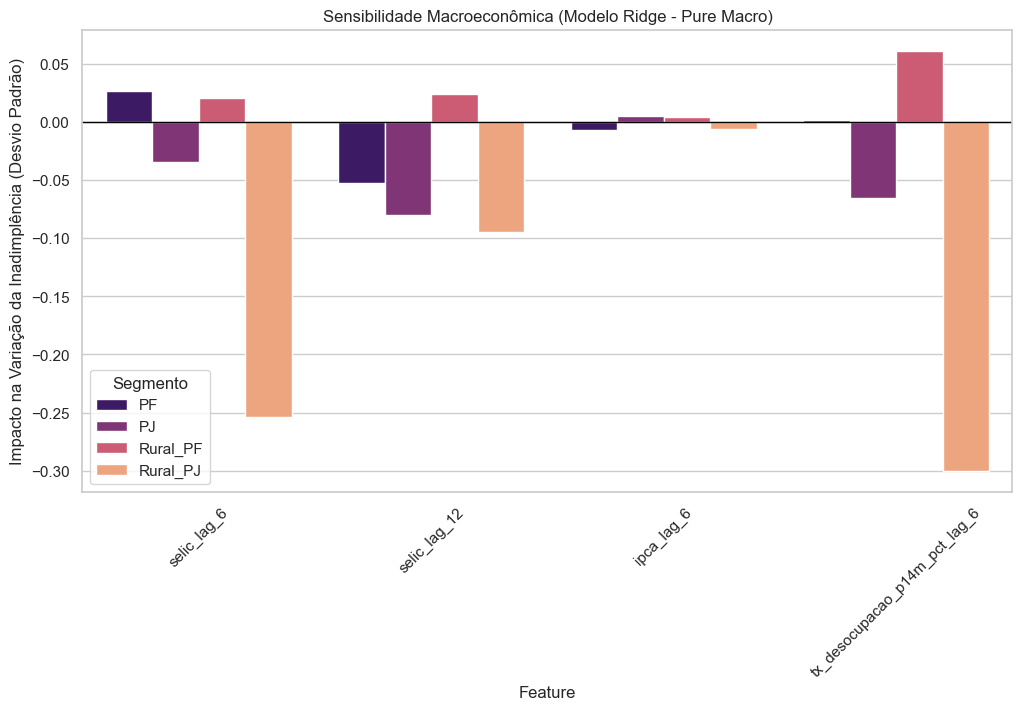


    INTERPRETAÇÃO DO GRÁFICO:
    - Barras para CIMA (>0): O aumento dessa variável AUMENTA a inadimplência.
    - Barras para BAIXO (<0): O aumento dessa variável REDUZ a inadimplência.
    


In [4]:
# --- 4. Visualização da Sensibilidade Macro ---

if resultados_coef:
    df_coefs = pd.concat(resultados_coef)
    
    mask_visual = df_coefs['Feature'].isin(['selic_lag_6', 'selic_lag_12', 'tx_desocupacao_p14m_pct_lag_6', 'ipca_lag_6'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_coefs[mask_visual], 
        x="Feature", 
        y="Coeficiente", 
        hue="Segmento",
        palette="magma"
    )
    plt.axhline(0, color='black', linewidth=1)
    plt.title("Sensibilidade Macroeconômica (Modelo Ridge - Pure Macro)")
    plt.ylabel("Impacto na Variação da Inadimplência (Desvio Padrão)")
    plt.xticks(rotation=45)
    plt.show()

    print("""
    INTERPRETAÇÃO DO GRÁFICO:
    - Barras para CIMA (>0): O aumento dessa variável AUMENTA a inadimplência.
    - Barras para BAIXO (<0): O aumento dessa variável REDUZ a inadimplência.
    """)

### Conclusão: Qual modelo usar no App?

Temos agora duas famílias de modelos salvas:

1.  **Modelos Autoregressivos (Pasta `models/`):** Têm alta precisão para o "mês que vem", pois sabem onde estamos hoje.
2.  **Modelos Pure Macro (Pasta `models/pure_macro/`):** Têm menor precisão imediata, mas respondem melhor a cenários hipotéticos de estresse (ex: "Crise Econômica").